# **Performance of clustering methods**
This notebook can be used to recreate the paper's figure about *clusTCR*'s performance, benchmarked against existing clustering approaches. To use the notebook, clone *clusTCR*'s github repository ([https://github.com/svalkiers/clusTCR](https://github.com/svalkiers/clusTCR)) onto your device and pasting the path to the repo down here.

In [1]:
import os

# Path to clusTCR repo goes here:
os.chdir('/home/sebastiaan/PhD/Repositories/clusTCR/')

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from clustcr.clustering.clustering import Clustering
from clustcr.input import datasets
from clustcr.modules.gliph2.gliph2 import GLIPH2
from clustcr.modules.ismart.ismart import iSMART
from clustcr.modules.tcrdist.pw_tcrdist import tcrdist

In [3]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)

## **Benchmarking**

In [17]:
sample_sizes = [500000, 750000, 1000000]
result = {'GLIPH2':[],
         'iSMART':[],
         'clusTCR':[],
         'tcrdist3*':[],
         'n_sequences':[]}

for s in sample_sizes:
    result['n_sequences'].append(s)

    # clusTCR and iSMART
    metarepertoire = datasets.metarepertoire(directory='/home/sebastiaan/PhD/Data/Emerson/emerson_cohort_1/',
                                             data_format='immuneaccess',
                                             out_format='CDR3',
                                             n_sequences=s)
    # clusTCR @ 8 CPUs
    t0 = time.time()
    ts = Clustering(n_cpus=8)
    ts.fit(metarepertoire)
    t1 = time.time()
    t = t1 - t0
    result['clusTCR'].append(t)
    print('Clustered %s sequences with clusTCR in %s minutes.' % (s, t/60))

    # iSMART @ 1 CPU
    if s > 200000:
        result['iSMART'].append(None)
    else:
        c, t = iSMART(metarepertoire)
        result['iSMART'].append(t)

    # GLIPH2
    metarepertoire = datasets.metarepertoire(directory='/home/sebastiaan/PhD/Data/Emerson/emerson_cohort_1/',
                                             data_format='immuneaccess',
                                             out_format='GLIPH2',
                                             n_sequences=s)
    c, t = GLIPH2(metarepertoire)
    result['GLIPH2'].append(t)
    
    # tcrdist3
    if s >= 200000:
        result['tcrdist3*'].append(None)
    else:
        metarepertoire = datasets.metarepertoire(directory='/home/sebastiaan/PhD/Data/Emerson/emerson_cohort_1/',
                                                 data_format='immuneaccess',
                                                 out_format='tcrdist',
                                                 n_sequences=s)
        c, t = tcrdist(metarepertoire)
        result['tcrdist3*'].append(t)

    pd.DataFrame(result).to_csv('/home/sebastiaan/PhD/Repositories/clusTCR/results/method_comparison_speed_3.tsv', sep='\t')

/home/sebastiaan/miniconda3/envs/tcr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (9,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/sebastiaan/miniconda3/envs/tcr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Clustered 500000 sequences with clusTCR in 2.3662568887074786 minutes.
Clustering 500000 sequences with GLIPH2.
Elapsed time: 5245.167548656464 seconds.
Clustered 750000 sequences with clusTCR in 3.6109737793604535 minutes.
Clustering 750000 sequences with GLIPH2.
Elapsed time: 6806.780915737152 seconds.
Clustered 1000000 sequences with clusTCR in 4.3412587682406105 minutes.
Clustering 1000000 sequences with GLIPH2.
Elapsed time: 9125.480459928513 seconds.


## **Plot results**

In [31]:
# Read data
data = pd.read_csv('results/method_comparison_speed.tsv', sep = '\t')

# Only consider number of input sequences <= 10**6
data = data[data['n_sequences']<=10**6]

In [73]:
avg = data.groupby(by='n_sequences').mean()
std = data.groupby(by='n_sequences').std()

with open('test_table.tsv', 'w') as f:
    for n in range(len(avg)):
        c = 0
        for i,j in zip(avg.iloc[n], std.iloc[n]):
            if c != 3: 
                f.write('%s $\pm$ %s \t' % (np.round(i,2),np.round(j,2)))
                c += 1
            else:
                f.write('%s $\pm$ %s \n' % (np.round(i,2),np.round(j,2)))

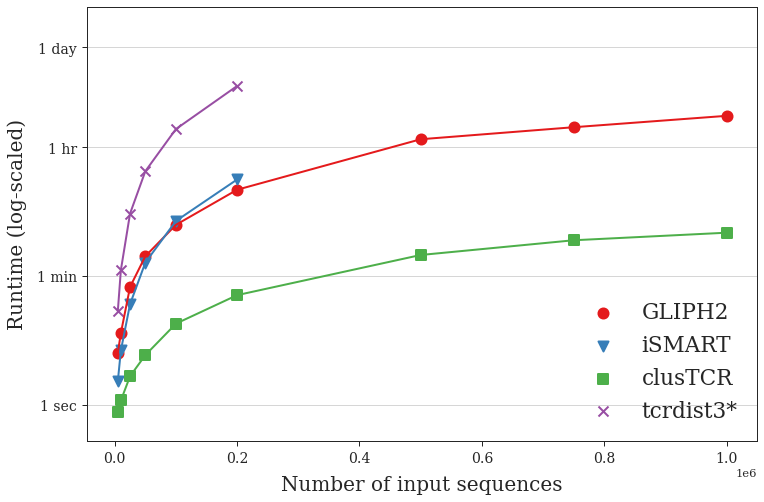

In [61]:
methods = data.columns[:-1]
n_seq = data[data.columns[-1]].unique()
colors = ['tab:blue', 'tab:orange', '']
markers = ["o", "v", "s", "x"]

fig, ax = plt.subplots(figsize=(12,8))
for (method, marker) in zip(methods, markers):
    ax.scatter(n_seq, y = np.log10(data.groupby(by='n_sequences').mean()[method]), 
               marker = marker, 
               s = 100, 
               linewidths = 2,  
               label = method,
               zorder = 1,
              )
    ax.plot(n_seq, np.log10(data.groupby(by='n_sequences').mean()[method]), 
            alpha = 1, 
            lw = 2,
            zorder = 2)

# ax.set_title('Speed of TCR clustering methods', fontsize = 32, y=1.04)
ax.set_xlabel('Number of input sequences', fontsize = 20, labelpad = 10)
ax.set_ylabel('Runtime (log-scaled)', fontsize = 20, labelpad = 10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.legend(fontsize = 'xx-large')

locs = np.log10([1,60,3600,86400])
labels = ["1 sec", "1 min", "1 hr", "1 day"]
plt.ylim((-0.5,5.5))
plt.yticks(ticks=locs, labels=labels)
plt.grid(axis='y')

fig.savefig('results/figures/method_comparison_speed_log.eps', format='eps')

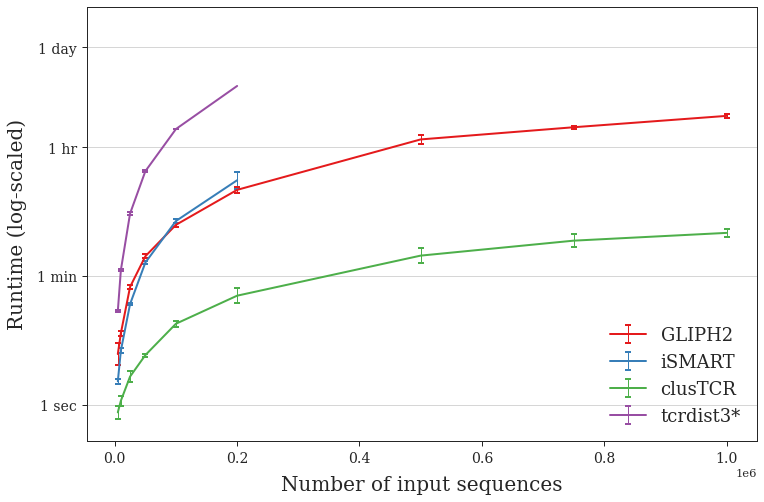

In [23]:
methods = data.columns[:-1]
n_seq = data[data.columns[-1]].unique()
colors = ['tab:blue', 'tab:orange', '']
markers = ["o", "v", "s", "x"]

# Plot data
fig, ax = plt.subplots(figsize=(12,8))
for (method, marker) in zip(methods, markers):
    ax.errorbar(x=n_seq, y=data.groupby(by='n_sequences').mean()[method],
                yerr=data.groupby(by='n_sequences').std()[method],
                capsize=3, elinewidth=1, markeredgewidth=2,
                linewidth=2, label=method
               )

# Make up axes
ax.set_xlabel('Number of input sequences', fontsize = 20, labelpad = 10)
ax.set_ylabel('Runtime (log-scaled)', fontsize = 20, labelpad = 10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.legend(fontsize = 'x-large')

locs = np.log10([1,60,3600,86400])
labels = ["1 sec", "1 min", "1 hr", "1 day"]
plt.ylim((-0.5,5.5))
plt.yticks(ticks=locs, labels=labels)
plt.grid(axis='y')

# Save figure
# fig.savefig('results/figures/method_comparison_speed_log.eps', format='eps')

AttributeError: 'Line2D' object has no property 's'

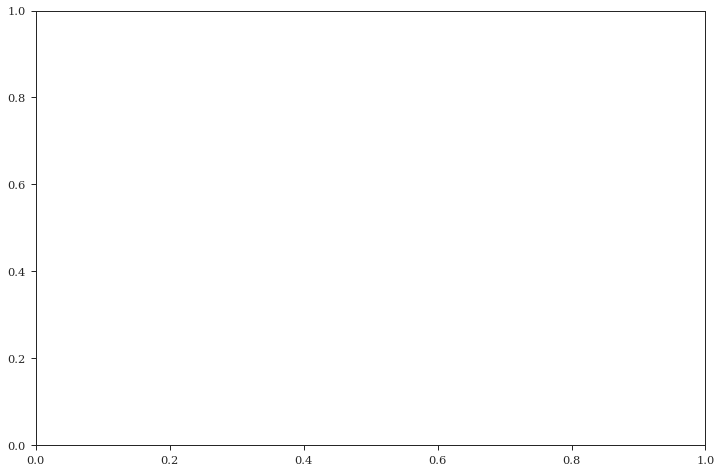

In [27]:
methods = data.columns[:-1]
n_seq = data[data.columns[-1]]
colors = ['tab:blue', 'tab:orange', '']
markers = ["o", "v", "s", "x"]

# Plot data
fig, ax = plt.subplots(figsize=(12,8))
for (method, marker) in zip(methods, markers):
    ax.scatter(n_seq, y = np.log10(data[method]), 
               marker = marker, 
               s = 100, 
               linewidths = 2,  
               label = method,
               zorder = 1,
              )
    ax.plot(n_seq, np.log10(data[method]), 
            alpha = 1, 
            lw = 2,
            zorder = 2)

# Make up axes
ax.set_xlabel('Number of input sequences', fontsize = 20, labelpad = 10)
ax.set_ylabel('Runtime (log-scaled)', fontsize = 20, labelpad = 10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.legend(fontsize = 'xx-large')

locs = np.log10([1,60,3600,86400])
labels = ["1 sec", "1 min", "1 hr", "1 day"]
plt.ylim((-0.5,5.5))
plt.yticks(ticks=locs, labels=labels)
plt.grid(axis='y')

# Save figure
# fig.savefig('results/figures/method_comparison_speed_log.eps', format='eps')